In [117]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List, Set

class Transaction:

    def __init__(
            self,
            region: int,
            read_set: Set[int],
            write_set: Set[int],
            start_time_ms: int,
            end_time_ms: int
        ):
        self.region = region
        self.read_set = read_set
        self.write_set = write_set
        self.start_time_ms = start_time_ms
        self.end_time_ms = end_time_ms

    def __repr__(self):
        return (
            f"Transaction(region={self.region}, read={self.read_set}, write={self.write_set}, "
            f"start={self.start_time_ms}, end={self.end_time_ms})"
        )

    def spatial_conflict(self, other):
        return (
            self.write_set.intersection(other.write_set) or
            self.read_set.intersection(other.write_set) or
            self.write_set.intersection(other.read_set)
        )
    
    def temporal_conflict(self, other):
        return (
            self.start_time_ms < other.end_time_ms and
            self.end_time_ms > other.start_time_ms
        )
    
    def conflict(self, other):
        return self.spatial_conflict(other) and self.temporal_conflict(other)
    

def pick(partition: Tuple[int, int], hot: int, is_hot: bool):
    if hot == 0:
        return random.randint(partition[0], partition[1] - 1)
    hot_boundary = partition[0] + hot
    if is_hot:
        return random.randint(partition[0], hot_boundary - 1)
    else:
        return random.randint(hot_boundary, partition[1] - 1)


def generate_read_write_sets(
    home_partition: Tuple[int, int],
    remote_partitions: List[Tuple[int, int]],
    params: dict,
) -> Tuple[Set[int], Set[int]]:
    hot = params["hot"]
    mr = params["mr"]
    
    k1 = pick(home_partition, hot, True)
    k2 = pick(home_partition, hot, False)
    if random.random() < mr:
        remote_partition = random.choice(remote_partitions)
        k3 = pick(remote_partition, hot, True)
        k4 = pick(remote_partition, hot, False)
    else:
        k3 = pick(home_partition, hot, True)
        k4 = pick(home_partition, hot, False)

    read_set = {k1, k2, k3, k4}
    write_set = read_set

    return read_set, write_set


def generate_workload_by_one_worker(
    region: int,
    params: dict,
) -> List[Transaction]:
    partitions = params["partitions"]
    total_duration_ms = params["total_duration_ms"]
    xact_duration_ms = params["xact_duration_ms"]
    xact_duration_variance_ms = params["xact_duration_variance_ms"]
    gap_duration_ms = params["gap_duration_ms"]

    home_partition = partitions[region]
    remote_partitions = partitions[:region] + partitions[region + 1:]
    transactions = []
    start_time = 0
    while start_time < total_duration_ms:
        end_time = start_time + xact_duration_ms + random.randint(
            -xact_duration_variance_ms, xact_duration_variance_ms
        )
        read_set, write_set = generate_read_write_sets(home_partition, remote_partitions, params)
        transactions.append(Transaction(region, read_set, write_set, start_time, end_time))
        start_time = end_time + gap_duration_ms
    
    return transactions


def find_aborts(schedule):
    sorted_schedule = sorted(schedule, key=lambda x: x.start_time_ms)
    aborted = set()
    for i in range(len(sorted_schedule)):
        for j in range(i + 1, len(sorted_schedule)):
            if sorted_schedule[j].start_time_ms > sorted_schedule[i].end_time_ms:
                break
            if sorted_schedule[i].conflict(sorted_schedule[j]):
                aborted.add(sorted_schedule[i])
                break

    return aborted
            

In [102]:
num_regions = 3
workers = 32

params = {
    "partitions": [(0, 10000), (10000, 20000), (20000, 30000)],
    "workers": 32,
    "num_regions": 3,
    "mr": 0,
    "hot": 0,
    "total_duration_ms": 10000,
    "xact_duration_ms": 20,
    "xact_duration_variance_ms": 5,
    "gap_duration_ms": 1,
}

schedule = []
for region in range(num_regions):
    for w in range(workers):
        schedule += generate_workload_by_one_worker(region, params)

aborted = find_aborts(schedule)
print("Number of transactions:", len(schedule))
print("Number of aborted transactions:", len(aborted))
print("Transaction per second:", (len(schedule) - len(aborted))  / (params["total_duration_ms"] / 1000))


Number of transactions: 45741
Number of aborted transactions: 2032
Transaction per second: 4370.9


In [ ]:

# Compute the number of conflicts transactions in the schedule
num_pairs = 0
spatial_conflicts = 0
temporal_conflicts = 0
conflicts = 0
for i in range(len(schedule)):
    for j in range(i + 1, len(schedule)):
        num_pairs += 1
        if schedule[i].spatial_conflict(schedule[j]):
            spatial_conflicts += 1
        if schedule[i].temporal_conflict(schedule[j]):
            temporal_conflicts += 1
        if schedule[i].conflict(schedule[j]):
            conflicts += 1

print(f"Number of transactions: {len(schedule)}")
print(f"Number of pairs: {num_pairs}")
print(f"Number of spatial conflicts: {spatial_conflicts}")
print(f"Number of temporal conflicts: {temporal_conflicts}")
print(f"Number of conflicts: {conflicts}")
print(f"Spatial conflict pct: {spatial_conflicts / num_pairs * 100:.2f}%")
print(f"Temporal conflict pct: {temporal_conflicts / num_pairs * 100:.2f}%")
print(f"Conflict pct: {conflicts / num_pairs * 100:.2f}%")


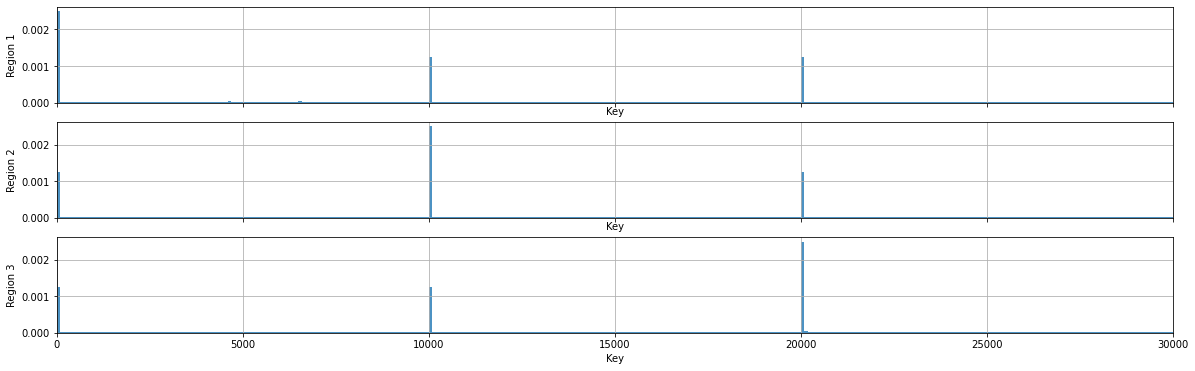

In [84]:
def collect_keys(schedule: List[Transaction]):
    records = []
    for xact in schedule:
        for key in xact.read_set.union(xact.write_set):
            records.append({
                "region": xact.region,
                "key": key,
            })
    return pd.DataFrame(records)


def plot_hists(schedule):
    num_regions = schedule.region.max() + 1
    fig, ax = plt.subplots(num_regions, 1, figsize=(20, 6), sharex=True, sharey=True)
    ax = [ax] if num_regions == 1 else ax
    for r in range(num_regions):
        schedule.loc[schedule.region == r, "key"].hist(density=True, ax=ax[r], bins=300, alpha=0.8)
        ax[r].set_xlim(0, 30000)
        ax[r].set_ylabel(f"Region {r+1}")
        ax[r].set_xlabel("Key")

plot_hists(collect_keys(schedule))

In [121]:
num_regions = 3
workers = 32

xact_duration = {
    (0, 0): 14,
    (0, 1000): 19,
    (0, 500): 22,
    (0, 100): 34,
    (0, 10): 4000,
    (0, 1): 16,
    (5, 0): 20,
    (5, 1000): 22,
    (5, 500): 24,
    (5, 100): 46,
    (5, 10): 4000,
    (5, 1): 25,
    (10, 0): 21,
    (10, 1000): 23,
    (10, 500): 25,
    (10, 100): 43,
    (10, 10): 4000,
    (10, 1): 27,
    (25, 0): 25,
    (25, 1000): 27,
    (25, 500): 30,
    (25, 100): 45,
    (25, 10): 4000,
    (25, 1): 1000,
    (50, 0): 31,
    (50, 1000): 35,
    (50, 500): 35,
    (50, 100): 58,
    (50, 10): 3000,
    (50, 1): 4000,
    (75, 0): 37,
    (75, 1000): 40,
    (75, 500): 44,
    (75, 100): 60,
    (75, 10): 3000,
    (75, 1): 7000,
    (100, 0): 38,
    (100, 1000): 42,
    (100, 500): 46,
    (100, 100): 65,
    (100, 10): 1000,
    (100, 1): 10000,
}

records = []
for mr in [0, 5, 10, 25, 50, 75, 100]:
    for hot in [0, 1000, 500, 100, 10, 1]:
        params = {
            "partitions": [(0, 10000), (10000, 20000), (20000, 30000)],
            "workers": 32,
            "num_regions": 3,
            "mr": mr,
            "hot": hot,
            "total_duration_ms": 10000,
            "xact_duration_ms": xact_duration[(mr, hot)], # type: ignore
            "xact_duration_variance_ms": 2,
            "gap_duration_ms": 2,
        }

        schedule = []
        for region in range(num_regions):
            for w in range(workers):
                schedule += generate_workload_by_one_worker(region, params)

        aborted = find_aborts(schedule)
        throughput = (len(schedule) - len(aborted))  / (params["total_duration_ms"] / 1000)

        records.append({
            "mr": mr,
            "hot": hot,
            "throughput": throughput,
        })
        print(f"mr={mr}, hot={hot}, throughput={throughput:.2f}")

result = pd.DataFrame(records)

mr=0, hot=0, throughput=4177.60


In [120]:
result.pivot(index="mr", columns="hot", values="throughput") * 3

hot,0
mr,
0,17259.0
